<a href="https://colab.research.google.com/github/shreytanwar/Deep-Belief-Network-For-Software-Fault-Prediction-II/blob/main/JustInTime_SW_Pred_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
import tensorflow as tf
import sklearn.metrics
from sklearn.metrics import log_loss, accuracy_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
df= pd.read_csv('/content/drive/My Drive/dataset/bugzilla.csv')

In [ ]:
def normalize(x):
  x = x.astype(float)
  min = np.min(x)
  max = np.max(x)
  return (x - min)/(max-min)

In [ ]:
def view_values(X, y, example):
    label = y.loc[example]
    image = X.loc[example,:].values.reshape([-1,1])
    print(image)

In [ ]:
print("Shape of dataframe: ", df.shape)   #train

Shape of dataframe:  (4620, 17)


In [ ]:
df.head()

,transactionid,commitdate,ns,nm,nf,entropy,la,ld,lt,fix,ndev,pd,npt,exp,rexp,sexp,bug
0,3,2001/12/12 17:41,1,1,3,0.579380,0.093620,0.000000,480.666667,1,14,596,0.666667,143,133.50,129,1
1,7,1999/10/12 12:57,1,1,1,0.000000,0.000000,0.000000,398.000000,1,1,0,1.000000,140,140.00,137,1
2,8,2002/5/15 16:55,3,3,52,0.739279,0.183477,0.208913,283.519231,0,23,15836,0.750000,984,818.65,978,0
3,9,2002/1/21 15:37,1,1,8,0.685328,0.016039,0.012880,514.375000,1,21,1281,1.000000,579,479.25,550,0
4,10,2001/12/19 16:44,2,2,38,0.769776,0.091829,0.072746,366.815789,1,21,6565,0.763158,413,313.25,405,0


### RBM


In [ ]:
# Define RBM class
class RBM(object):
    
    def __init__(self, input_size, output_size, 
                 learning_rate, epochs, batchsize):
        # Define hyperparameters
        self._input_size = input_size
        self._output_size = output_size
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.batchsize = batchsize
        
        # Initialize weights and biases using zero matrices
        self.w = np.zeros([input_size, output_size], dtype=np.float32)
        self.hb = np.zeros([output_size], dtype=np.float32)
        self.vb = np.zeros([input_size], dtype=np.float32)
    # forward pass, where h is the hidden layer and v is the visible layer
    def prob_h_given_v(self, visible, w, hb):
        return tf.nn.sigmoid(tf.matmul(visible, w) + hb)
    # backward pass
    def prob_v_given_h(self, hidden, w, vb):
        return tf.nn.sigmoid(tf.matmul(hidden, tf.transpose(w)) + vb)
    # sampling function
    def sample_prob(self, probs):
        return tf.nn.relu(tf.sign(probs - tf.random_uniform(tf.shape(probs))))

    def train(self, X):
        _w = tf.placeholder(tf.float32, [self._input_size, self._output_size])
        _hb = tf.placeholder(tf.float32, [self._output_size])
        _vb = tf.placeholder(tf.float32, [self._input_size])
        
        prv_w = np.zeros([self._input_size, self._output_size], dtype=np.float32)
        prv_hb = np.zeros([self._output_size], dtype=np.float32)
        prv_vb = np.zeros([self._input_size], dtype=np.float32)
        
        cur_w = np.zeros([self._input_size, self._output_size], dtype=np.float32)
        cur_hb = np.zeros([self._output_size], dtype=np.float32)
        cur_vb = np.zeros([self._input_size], dtype=np.float32)
        
        v0 = tf.placeholder(tf.float32, [None, self._input_size])
        h0 = self.sample_prob(self.prob_h_given_v(v0, _w, _hb))
        v1 = self.sample_prob(self.prob_v_given_h(h0, _w, _vb))
        h1 = self.prob_h_given_v(v1, _w, _hb)
        #To update the weights, we perform constrastive divergence.
        positive_grad = tf.matmul(tf.transpose(v0), h0)
        negative_grad = tf.matmul(tf.transpose(v1), h1)
        
        update_w = _w + self.learning_rate * (positive_grad - negative_grad) / tf.to_float(tf.shape(v0)[0])
        update_vb = _vb +  self.learning_rate * tf.reduce_mean(v0 - v1, 0)
        update_hb = _hb +  self.learning_rate * tf.reduce_mean(h0 - h1, 0)
        # We also define the error as the MSE
        err = tf.reduce_mean(tf.square(v0 - v1))
        
        error_list = []

        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            
            for epoch in range(self.epochs):
                for start, end in zip(range(0, len(X),  self.batchsize),range(self.batchsize,len(X), self.batchsize)):
                    batch = X[start:end]
                    cur_w = sess.run(update_w, feed_dict={v0: batch, _w: prv_w, _hb: prv_hb, _vb: prv_vb})
                    cur_hb = sess.run(update_hb, feed_dict={v0: batch,  _w: prv_w, _hb: prv_hb, _vb: prv_vb})
                    cur_vb = sess.run(update_vb, feed_dict={v0: batch, _w: prv_w, _hb: prv_hb, _vb: prv_vb})
                    prv_w = cur_w
                    prv_hb = cur_hb
                    prv_vb = cur_vb
                error = sess.run(err, feed_dict={v0: X, _w: cur_w, _vb: cur_vb, _hb: cur_hb})
                print ('Epoch: %d' % epoch,'reconstruction error: %f' % error)
                error_list.append(error)
            self.w = prv_w
            self.hb = prv_hb
            self.vb = prv_vb
            return error_list
    #function to generate new features from the generative model that the RBM has learned
    def rbm_output(self, X):
        
        input_X = tf.constant(X)
        _w = tf.constant(self.w)
        _hb = tf.constant(self.hb)
        _vb = tf.constant(self.vb)
        out = tf.nn.sigmoid(tf.matmul(input_X, _w) + _hb)
        hiddenGen = self.sample_prob(self.prob_h_given_v(input_X, _w, _hb))
        visibleGen = self.sample_prob(self.prob_v_given_h(hiddenGen, _w, _vb))
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            return sess.run(out), sess.run(visibleGen), sess.run(hiddenGen)

## Training

In [ ]:
#More Balanced DataFrame
deleted = 0
for i in range(0, df.shape[0]-1):
  if deleted == 1230:
    break
  elif df.iloc[i].bug == 0:
    df = df.drop(df.index[i])
    deleted = deleted + 1

In [ ]:
#Droping unnecessary String columns
df = df.drop(['commitdate','transactionid'], axis=1)

In [ ]:
#Split df
train_X = df.iloc[:,:-1].apply(func=normalize, axis=0)
train_Y = df.iloc[:,-1]

In [ ]:
# df=df.drop(['transactionid'], axis=1)
print(df.head())

   ns  nm  nf   entropy        la  ...       npt  exp    rexp  sexp  bug
0   1   1   3  0.579380  0.093620  ...  0.666667  143  133.50   129    1
1   1   1   1  0.000000  0.000000  ...  1.000000  140  140.00   137    1
3   1   1   8  0.685328  0.016039  ...  1.000000  579  479.25   550    0
5   1   1  16  0.760777  0.018308  ...  0.750000  595  495.25   566    0
7   2   2  33  0.816160  0.095682  ...  0.727273  482  382.25   474    0

[5 rows x 15 columns]


In [ ]:
inputX = df.iloc[:,:-1].apply(func=normalize, axis=0).values
inputY= df.iloc[:,-1].values
print(type(inputX))
inputX = inputX.astype(np.float32)

#List to hold RBMs
rbm_list = []

#define parameters of RBMs we will train
# 14-20-12-12-2

# def __init__(self, input_size, output_size,learning_rate, epochs, batchsize):
rbm_list.append(RBM(14, 20, 1.000, 150, 100))
rbm_list.append(RBM(20, 12, 1.000, 150, 100))
rbm_list.append(RBM(12, 12, 1.000, 150, 100))

<class 'numpy.ndarray'>


In [ ]:
inputX.shape

(3390, 14)

In [ ]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior() 

Instructions for updating:
non-resource variables are not supported in the long term


In [ ]:
outputList = []
error_list = []

#For each RBM in out list
for i in range(0, len(rbm_list)):
    print('RBM', i+1)
    #Train new RBM
    rbm = rbm_list[i]
    err = rbm.train(inputX)
    error_list.append(err)

    #Return output layer
    #sess.run(out), sess.run(visibleGen), sess.run(hiddenGen)
    outputX, reconstructedX, hiddenX = rbm.rbm_output(inputX)
    outputList.append(outputX)
    inputX= hiddenX

RBM 1
Instructions for updating:
Use `tf.cast` instead.
Epoch: 0 reconstruction error: 0.113313
Epoch: 1 reconstruction error: 0.117359
Epoch: 2 reconstruction error: 0.114953
Epoch: 3 reconstruction error: 0.111951
Epoch: 4 reconstruction error: 0.110032
Epoch: 5 reconstruction error: 0.111399
Epoch: 6 reconstruction error: 0.111426
Epoch: 7 reconstruction error: 0.108291
Epoch: 8 reconstruction error: 0.109852
Epoch: 9 reconstruction error: 0.107341
Epoch: 10 reconstruction error: 0.103858
Epoch: 11 reconstruction error: 0.107152
Epoch: 12 reconstruction error: 0.108607
Epoch: 13 reconstruction error: 0.102160
Epoch: 14 reconstruction error: 0.106119
Epoch: 15 reconstruction error: 0.107382
Epoch: 16 reconstruction error: 0.108130
Epoch: 17 reconstruction error: 0.105707
Epoch: 18 reconstruction error: 0.106528
Epoch: 19 reconstruction error: 0.107380
Epoch: 20 reconstruction error: 0.104736
Epoch: 21 reconstruction error: 0.103602
Epoch: 22 reconstruction error: 0.104454
Epoch: 23 r

RBM 1


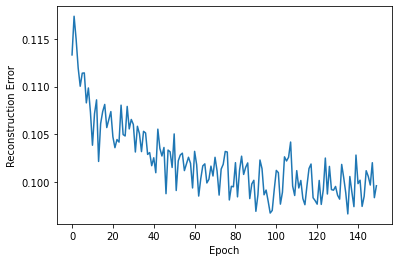

RBM 2


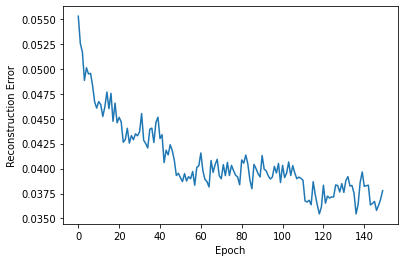

RBM 3


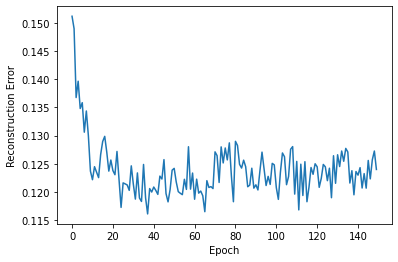

In [ ]:
i = 1
for err in error_list:
    print("RBM",i)
    pd.Series(err).plot(logy=False)
    plt.xlabel("Epoch")
    plt.ylabel("Reconstruction Error")
    plt.show()
    i += 1

In [ ]:
outputX.shape

(3390, 12)

##**Classifier**(ANN)


Used outputX as the Input for the Classifer

Artificial Neural Network Classifier

In [ ]:
import keras
from keras.models import Sequential
from keras.layers import Dense

In [ ]:
Y_Train = train_Y.iloc[:3051].values
# Y_Train.shape

Y_Test = train_Y.iloc[3052:].values
Y_Test.shape

(338,)

In [ ]:
X_New_Train = outputX
X_New_Train = X_New_Train[:3051, :]
Y_Train = Y_Train.reshape((-1,1))

In [ ]:
X_Test = outputX
X_Test = X_Test[3052:, :]

In [ ]:
classifier = Sequential()

# CHECK outputX_DBN for input dim
classifier.add(Dense (6, activation = 'relu', input_dim = 12))

#hidden
classifier.add(Dense (6, activation = 'relu'))

#output
classifier.add(Dense(1, activation = 'sigmoid'))
# optimizer = keras.optimizers.Adam(lr=0.002)
# classifier.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ['accuracy'])

classifier.compile(optimizer = 'Adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

classifier.fit(X_New_Train, Y_Train, batch_size = 100, epochs = 200)

Train on 3051 samples
Epoch 1/200
3051/3051 [==============================] - 0s 12us/sample - loss: 0.7015 - acc: 0.4782
Epoch 2/200
3051/3051 [==============================] - 0s 9us/sample - loss: 0.6934 - acc: 0.5015
Epoch 3/200
3051/3051 [==============================] - 0s 9us/sample - loss: 0.6904 - acc: 0.5477
Epoch 4/200
3051/3051 [==============================] - 0s 10us/sample - loss: 0.6891 - acc: 0.5726
Epoch 5/200
3051/3051 [==============================] - 0s 11us/sample - loss: 0.6880 - acc: 0.5719
Epoch 6/200
3051/3051 [==============================] - 0s 10us/sample - loss: 0.6869 - acc: 0.5736
Epoch 7/200
3051/3051 [==============================] - 0s 10us/sample - loss: 0.6857 - acc: 0.5752
Epoch 8/200
3051/3051 [==============================] - 0s 11us/sample - loss: 0.6845 - acc: 0.5752
Epoch 9/200
3051/3051 [==============================] - 0s 13us/sample - loss: 0.6833 - acc: 0.5755
Epoch 10/200
3051/3051 [==============================] - 0s 13us/sampl

In [ ]:
y_pred = classifier.predict(outputX)
y_pred = (y_pred > 0.5)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


In [ ]:
pred = (train_Y[3052:] > 0.5)
yty = np. count_nonzero(pred) 
yty


104

In [ ]:
outputX.shape

(3390, 12)

##Confusion Matrix

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(train_Y[3051:], y_pred[3051:])
print(cm) 

[[ 90 145]
 [ 29  75]]


###F1 Score

In [ ]:
def f1score( tn, fp, fn, tp):
  precision = tp/(tp + fp)
  print('precision',precision)
  recall = tp/(tp+fn)
  print('recall',recall)
  return 2 * (precision * recall) / (precision + recall)

In [ ]:
tn, fp, fn, tp = confusion_matrix(train_Y, y_pred, labels=[0,1]).ravel()
print(f1score(tn, fp, fn, tp))

precision 0.5503909643788011
recall 0.7470518867924528
0.6338169084542271
